# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

In [2]:
customer = pd.read_csv('/kaggle/input/retail-fashion-data/customer_data.csv')
product = pd.read_csv('/kaggle/input/retail-fashion-data/product_data.csv')
sales = pd.read_csv('/kaggle/input/retail-fashion-data/sales_data.csv')
store = pd.read_csv('/kaggle/input/retail-fashion-data/store_data.csv')

# Data Summary

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Customer Data")
display(check(customer))
display(customer.head())

print("Product Data")
display(check(product))
display(product.head())

print("Sales Data")
display(check(sales))
display(sales.head())

print("Store Data")
display(check(store))
display(store.head())

Customer Data


,column,dtype,instances,unique,sum_null,duplicates
customer_id,customer_id,object,2500,2500,0,0
age,age,int64,2500,54,0,0
gender,gender,object,2500,4,0,0
city,city,object,2500,5,0,0
email,email,object,2450,2450,50,0


,customer_id,age,gender,city,email
0,C00001,20,Female,Faro,user1@example.com
1,C00002,35,Male,Porto,user2@example.com
2,C00003,53,Other,Porto,user3@example.com
3,C00004,52,Female,Porto,NaN
4,C00005,32,Other,Lisbon,user5@example.com


Product Data


,column,dtype,instances,unique,sum_null,duplicates
product_id,product_id,object,5000,5000,0,0
category,category,object,5000,6,0,0
color,color,object,4900,6,100,0
size,size,object,5000,5,0,0
season,season,object,5000,4,0,0
supplier,supplier,object,5000,4,0,0
cost_price,cost_price,float64,5000,3606,0,0
list_price,list_price,float64,5000,4428,0,0


,product_id,category,color,size,season,supplier,cost_price,list_price
0,P00001,Bottoms,Yellow,XL,Summer,supplierc,27.66,114.26
1,P00002,Accessories,Yellow,S,Winter,supplierd,71.70,40.15
2,P00003,Tops,Blue,XS,Summer,supplierc,62.39,63.73
3,P00004,Accessories,Green,M,Fall,suppliera,32.73,68.33
4,P00005,Accessories,White,L,Summer,supplierd,17.53,51.66


Sales Data


,column,dtype,instances,unique,sum_null,duplicates
transaction_id,transaction_id,object,5000,5000,0,0
date,date,object,5000,601,0,0
product_id,product_id,object,5000,3165,0,0
store_id,store_id,object,5000,6,0,0
customer_id,customer_id,object,4801,2152,199,0
quantity,quantity,int64,5000,4,0,0
discount,discount,float64,4767,4,233,0
returned,returned,int64,5000,2,0,0


,transaction_id,date,product_id,store_id,customer_id,quantity,discount,returned
0,T000001,2022-09-13,P04687,S004,C02488,4,0.1,1
1,T000002,2022-05-08,P02631,S004,C01553,1,0.1,0
2,T000003,2023-03-07,P04644,S002,C00093,3,0.0,1
3,T000004,2022-09-19,P04654,S003,C01614,1,0.2,0
4,T000005,2023-05-25,P00224,S003,NaN,4,NaN,0


Store Data


,column,dtype,instances,unique,sum_null,duplicates
store_id,store_id,object,5,5,0,0
store_name,store_name,object,5,5,0,0
region,region,object,5,5,0,0
store_size_m2,store_size_m2,int64,5,5,0,0


,store_id,store_name,region,store_size_m2
0,S001,Lisbon Flagship,Lisbon,768
1,S002,Porto Center,Porto,162
2,S003,Faro Outlet,Algarve,782
3,S004,Online,Online,538
4,S005,Coimbra Boutique,Coimbra,646


# Merge Dataframes 

In [4]:
# Join Strategy how="left": Keeps all transactions, even if product/store/customer has invalid/missing IDs.

# Merge sales with product info
merged_df = sales.merge(product, on="product_id", how="left")

# Merge store info
merged_df = merged_df.merge(store, on="store_id", how="left")

# Merge customer info
merged_df = merged_df.merge(customer, on="customer_id", how="left")
# Check first 5 rows
#merged_df.head()

# Cleaning Pipeline 🧹

In [5]:
import re #regex

class CleaningPipeline:
    """
    Data cleaning pipeline for retail transaction datasets.
    Focused purely on structural and logical cleaning — no imputations.
    """

    def __init__(self):
        pass

    def _standardize_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df.columns = (
            df.columns.str.strip()
            .str.lower()
            .str.replace(r'[^a-z0-9]+', '_', regex=True)
        )
        return df

    def _convert_types(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

        numeric_cols = ['quantity', 'discount', 'cost_price', 'list_price', 'store_size_m2', 'age']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        if 'returned' in df.columns:
            df['returned'] = df['returned'].astype('Int64')

        return df

    def _deduplicate(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy().drop_duplicates()

        if 'transaction_id' in df.columns and not df['transaction_id'].is_unique:
            raise ValueError("Duplicate transaction_id values detected.")

        return df

    def _apply_sanity_checks(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if 'quantity' in df.columns:
            df = df[df['quantity'] > 0]

        if 'discount' in df.columns:
            df = df[(df['discount'] >= 0) & (df['discount'] <= 1)]

        if set(['cost_price', 'list_price']).issubset(df.columns):
            df = df[df['cost_price'] < df['list_price']]

        if 'age' in df.columns:
            df = df[(df['age'] >= 12) & (df['age'] <= 100)]

        return df

    def _normalize_categoricals(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        categorical_cols = [
            'category', 'color', 'gender', 'region',
            'store_name', 'city', 'supplier'
        ]

        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip().str.title()

        if 'supplier' in df.columns:
            df['supplier'] = (
                df['supplier']
                .str.strip()
                .str.lower()
                .str.replace(r'[^a-z0-9]+', '', regex=True)
                .str.replace(r'supplier', 'Supplier_', regex=False)
                .str.replace(r'([a-z])$', lambda m: m.group(1).upper(), regex=True)
            )

        return df

    def _feature_engineering(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if set(['list_price', 'quantity', 'discount']).issubset(df.columns):
            df['revenue'] = df['list_price'] * df['quantity'] * (1 - df['discount'])

        if set(['list_price', 'cost_price', 'quantity']).issubset(df.columns):
            df['profit'] = (df['list_price'] - df['cost_price']) * df['quantity']

        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['weekday'] = df['date'].dt.day_name()

        return df

    def _validate_emails(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if 'email' in df.columns:
            df['valid_email'] = df['email'].apply(
                lambda x: bool(re.match(r"[^@]+@[^@]+\.[^@]+", str(x)))
            )

        return df

    def fit(self, df: pd.DataFrame):
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = self._standardize_column_names(df)
        df = self._convert_types(df)
        df = self._deduplicate(df)
        df = self._apply_sanity_checks(df)
        df = self._normalize_categoricals(df)
        df = self._feature_engineering(df)
        df = self._validate_emails(df)
        df = df.reset_index(drop=True)
        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)


In [6]:
# Initialize and clean
cleaner = CleaningPipeline()
df_clean = cleaner.fit_transform(merged_df)

# Visual Insights

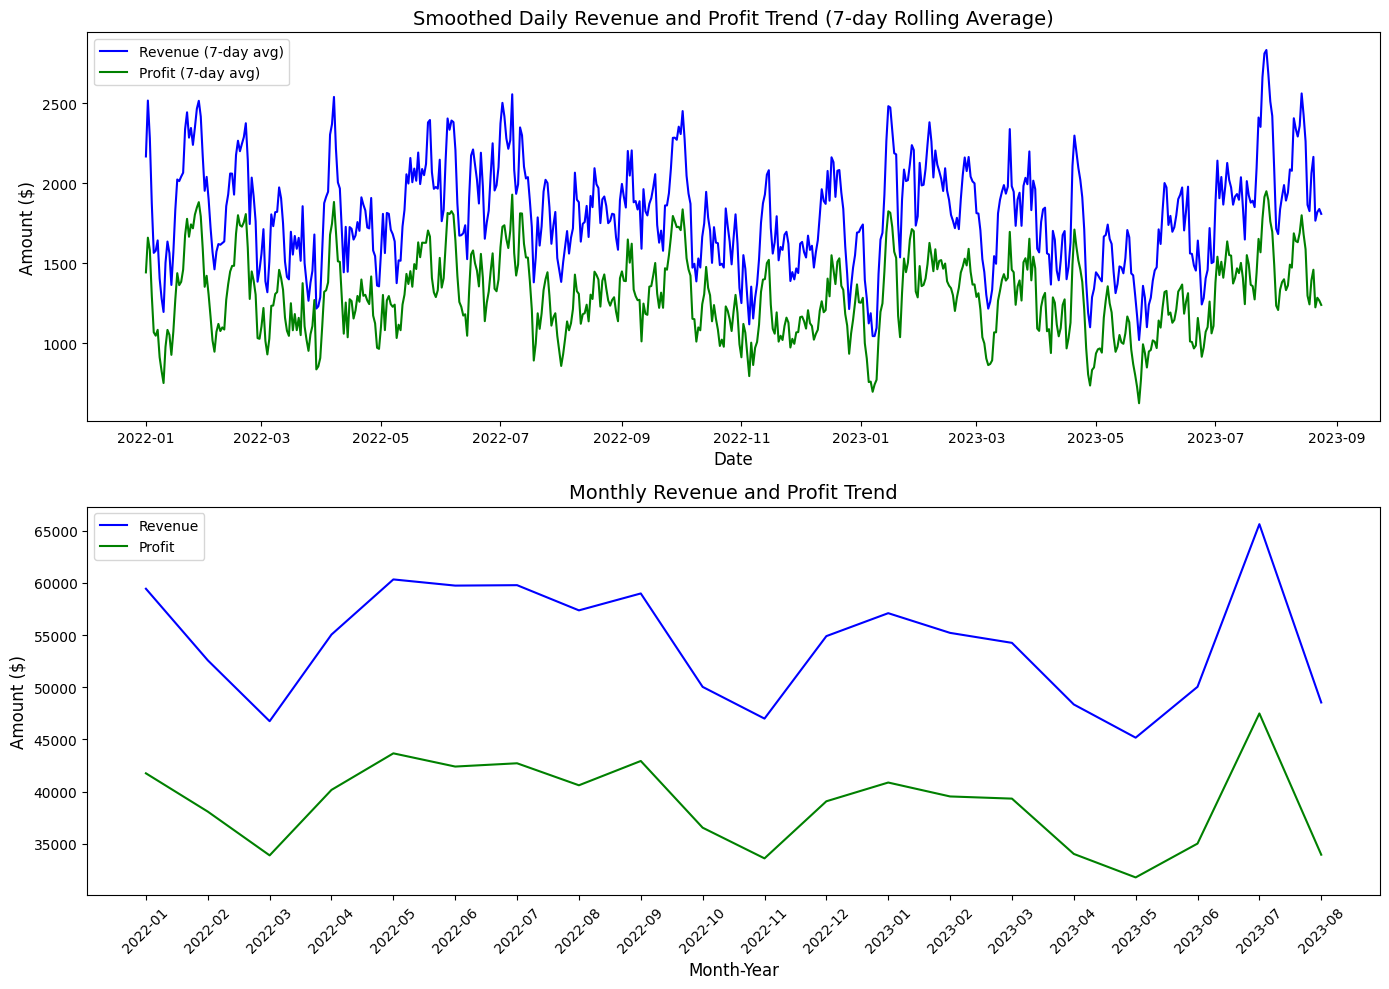

In [7]:
# Aggregate daily sales
daily = df_clean.groupby('date')[['revenue', 'profit']].sum().reset_index()

# Calculate 7-day rolling averages
daily['revenue_rolling'] = daily['revenue'].rolling(window=7, min_periods=1).mean()
daily['profit_rolling'] = daily['profit'].rolling(window=7, min_periods=1).mean()

# Aggregate by month
daily['month_year'] = daily['date'].dt.to_period('M').astype(str)  # Convert to string
monthly = daily.groupby('month_year')[['revenue', 'profit']].sum().reset_index()

# Create one figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Plot smoothed daily data on first subplot
sns.lineplot(data=daily, x='date', y='revenue_rolling', label='Revenue (7-day avg)', color='blue', ax=axs[0])
sns.lineplot(data=daily, x='date', y='profit_rolling', label='Profit (7-day avg)', color='green', ax=axs[0])
axs[0].set_title("Smoothed Daily Revenue and Profit Trend (7-day Rolling Average)", fontsize=14)
axs[0].set_xlabel("Date", fontsize=12)
axs[0].set_ylabel("Amount ($)", fontsize=12)
axs[0].legend()

# Plot monthly aggregated data on second subplot
sns.lineplot(data=monthly, x='month_year', y='revenue', label='Revenue', color='blue', ax=axs[1])
sns.lineplot(data=monthly, x='month_year', y='profit', label='Profit', color='green', ax=axs[1])
axs[1].set_title("Monthly Revenue and Profit Trend", fontsize=14)
axs[1].set_xlabel("Month-Year", fontsize=12)
axs[1].set_ylabel("Amount ($)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()

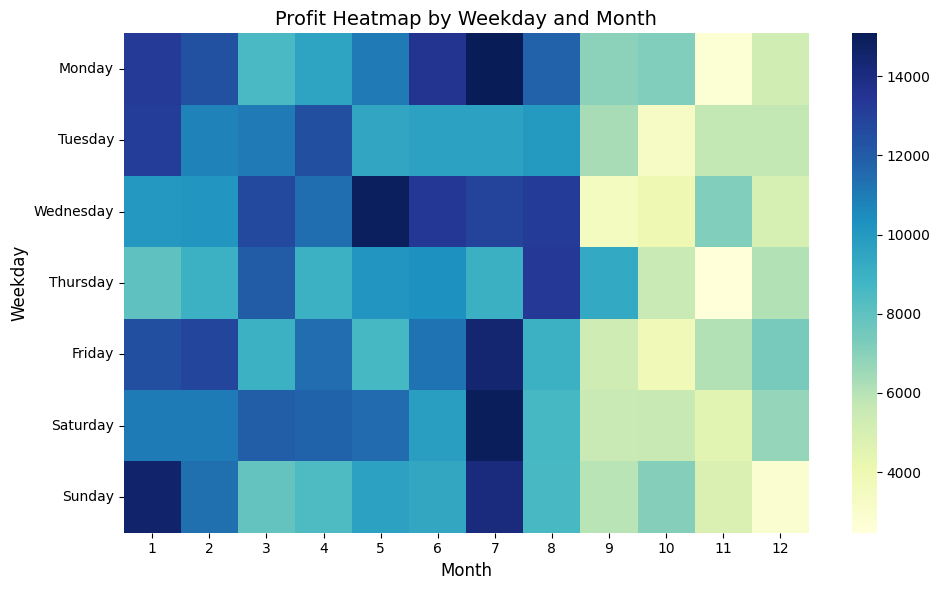

In [8]:
# Define the correct order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Ensure 'weekday' is categorical with the specified order
df_clean['weekday'] = pd.Categorical(df_clean['weekday'], categories=weekday_order, ordered=True)

# Group by weekday and month, then create the heatmap
heat = df_clean.groupby(['weekday', 'month'])['profit'].sum().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heat, cmap='YlGnBu', annot=False, fmt='.0f')
plt.title("Profit Heatmap by Weekday and Month", fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weekday', fontsize=12)
plt.tight_layout()
plt.show()

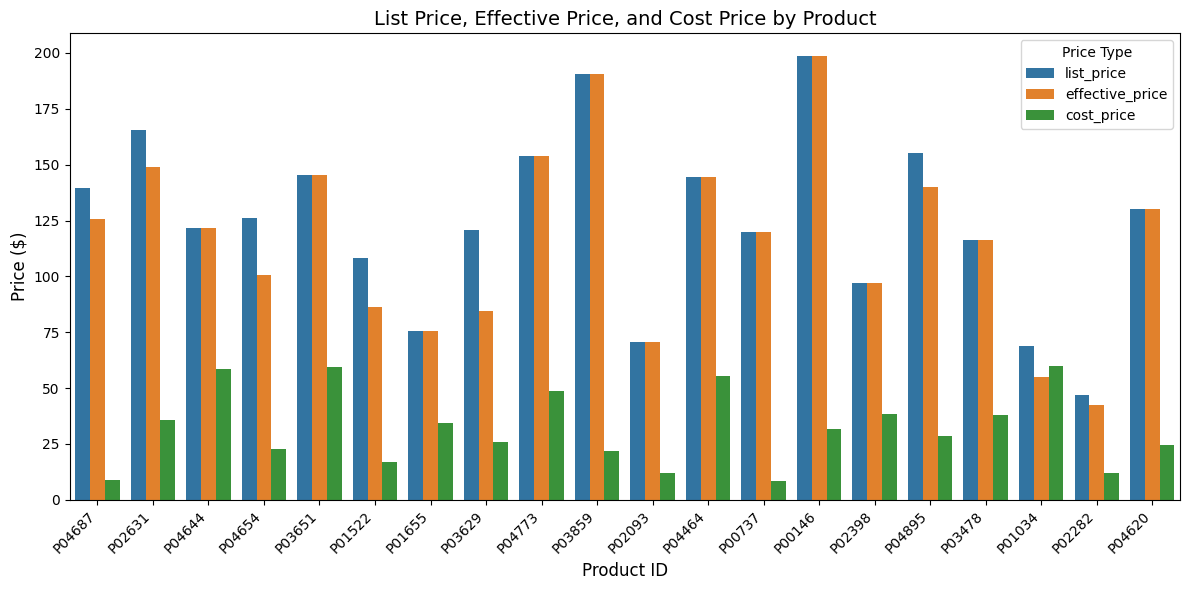

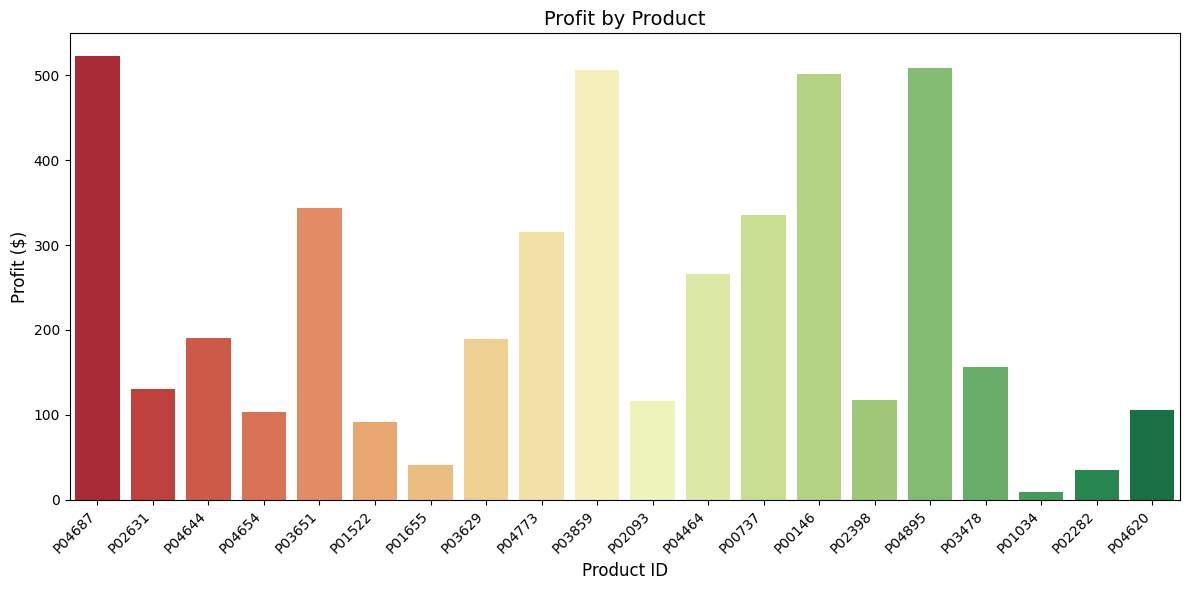

In [9]:
# Calculate effective selling price
df_clean['effective_price'] = df_clean['revenue'] / df_clean['quantity']

# Select a sample of products for clarity (e.g., first 20 unique products)
sample_products = df_clean[['product_id', 'list_price', 'effective_price', 'cost_price', 'profit']].drop_duplicates('product_id').head(20)

# Melt the DataFrame for plotting
melted_df = sample_products.melt(id_vars='product_id', value_vars=['list_price', 'effective_price', 'cost_price'], 
                                 var_name='Price_Type', value_name='Price')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='Price', hue='Price_Type', data=melted_df)
plt.title('List Price, Effective Price, and Cost Price by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Price Type')
plt.tight_layout()
plt.show()

# Plot profit separately to avoid scale issues
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='profit', data=sample_products, palette='RdYlGn')
plt.title('Profit by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

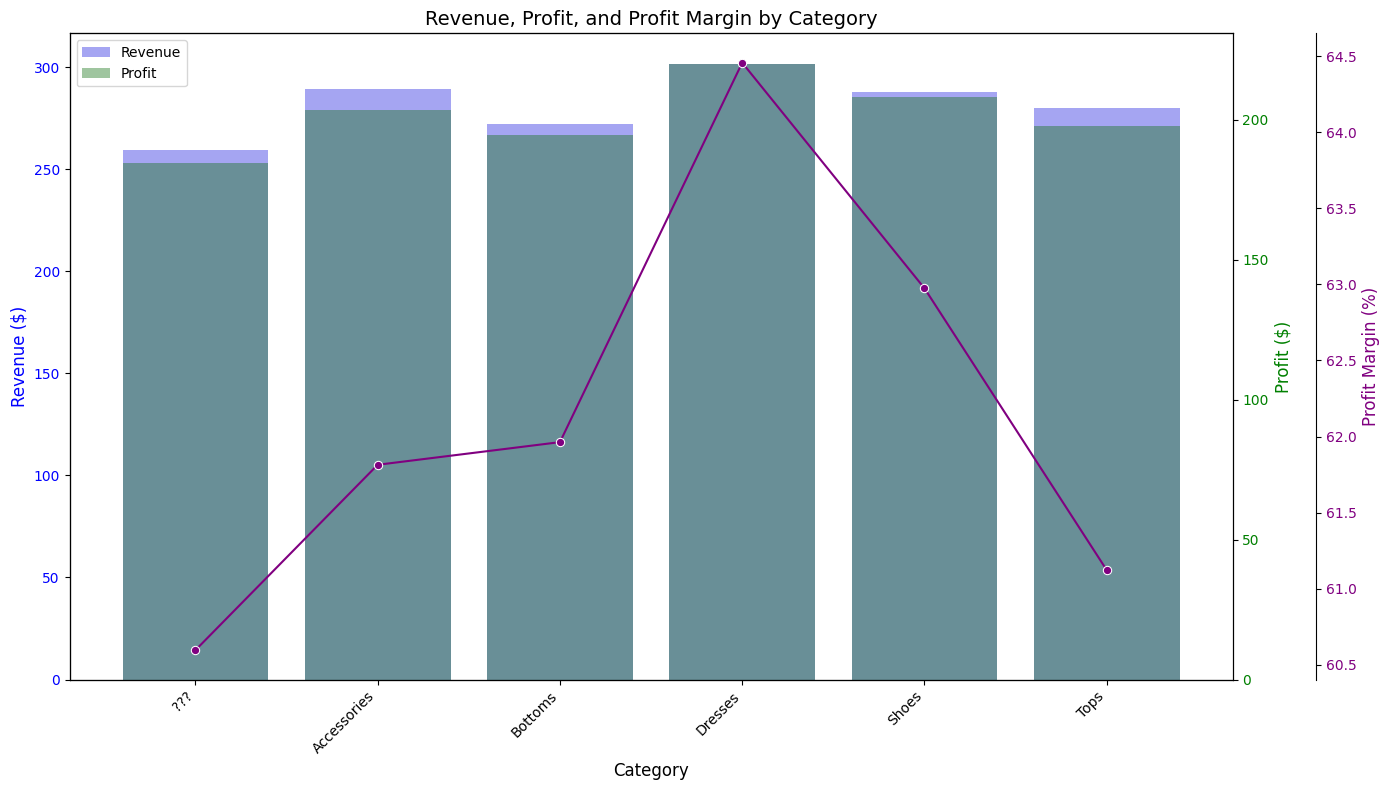

In [10]:
df_clean['profit_margin'] = ((df_clean['list_price'] - df_clean['cost_price']) / df_clean['list_price']) * 100
margin_by_supplier = df_clean.groupby('supplier')['profit_margin'].mean().sort_values()

# Aggregate by category
category_agg = df_clean.groupby('category')[['revenue', 'profit', 'profit_margin']].mean().reset_index()

# Bar plot with dual axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot revenue and profit
sns.barplot(data=category_agg, x='category', y='revenue', color='blue', alpha=0.4, label='Revenue', ax=ax1)
ax1.set_ylabel('Revenue ($)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Category', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Secondary axis for profit
ax2 = ax1.twinx()
sns.barplot(data=category_agg, x='category', y='profit', color='green', alpha=0.4, label='Profit', ax=ax2)
ax2.set_ylabel('Profit ($)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Line plot for profit margin
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset third axis
sns.lineplot(data=category_agg, x='category', y='profit_margin', color='purple', marker='o', ax=ax3)
ax3.set_ylabel('Profit Margin (%)', color='purple', fontsize=12)
ax3.tick_params(axis='y', labelcolor='purple')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
plt.title('Revenue, Profit, and Profit Margin by Category', fontsize=14)
plt.tight_layout()
plt.show()

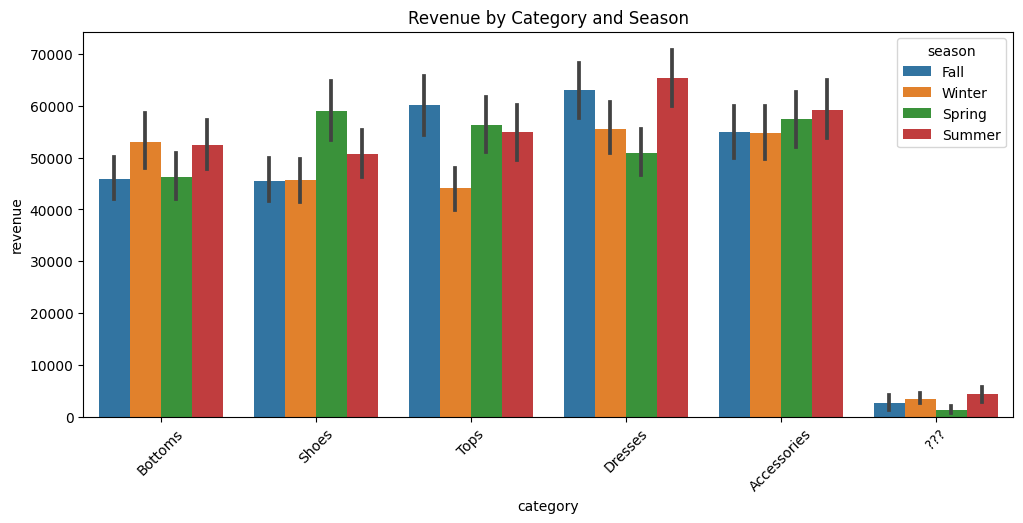

In [11]:
# Revenue by category and season
plt.figure(figsize=(12,5))
sns.barplot(data=df_clean, x='category', y='revenue', hue='season', estimator='sum')
plt.title("Revenue by Category and Season")
plt.xticks(rotation=45)
plt.show()

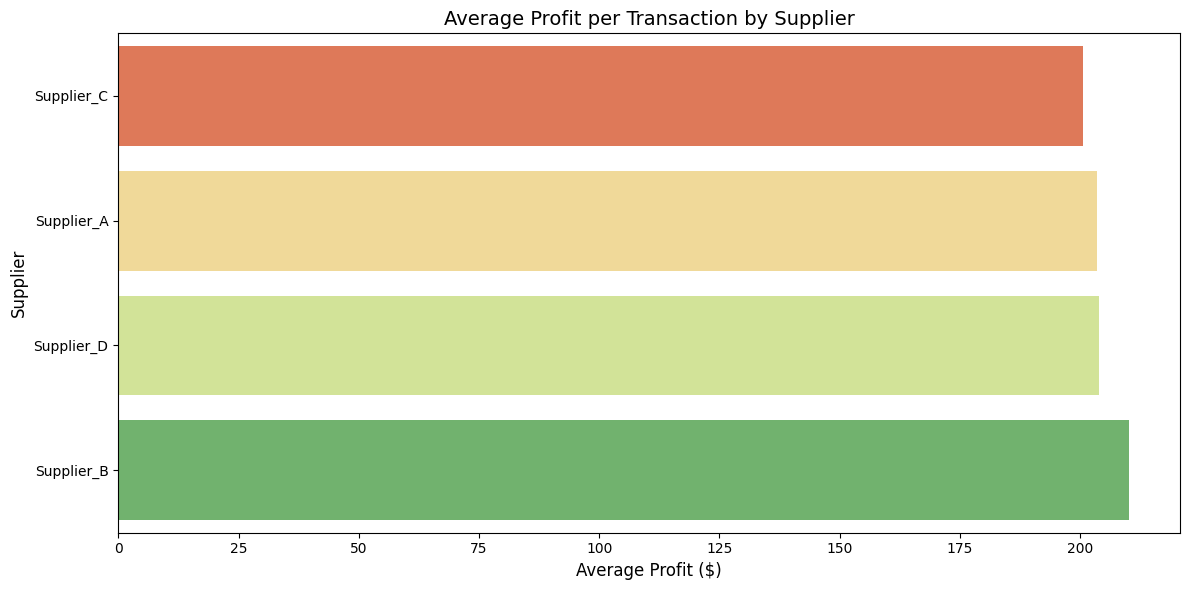

In [12]:
avg_profit_by_supplier = df_clean.groupby('supplier')['profit'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_profit_by_supplier.values, y=avg_profit_by_supplier.index, palette='RdYlGn')
plt.title('Average Profit per Transaction by Supplier', fontsize=14)
plt.xlabel('Average Profit ($)', fontsize=12)
plt.ylabel('Supplier', fontsize=12)
plt.tight_layout()
plt.show()

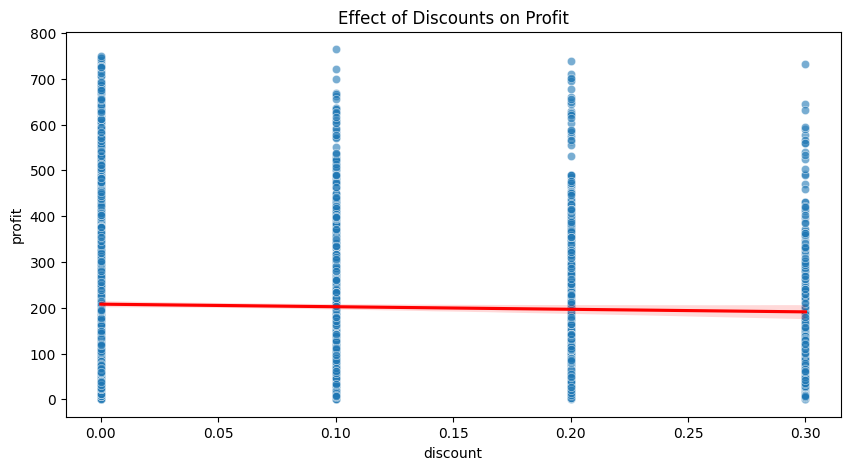

In [13]:
# Discount vs Profit relationship
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_clean, x='discount', y='profit', alpha=0.6)
sns.regplot(data=df_clean, x='discount', y='profit', scatter=False, color='red')
plt.title("Effect of Discounts on Profit")
plt.show()

*Even at higher discounts (e.g., 0.25–0.30), some transactions still yield profits above 200, suggesting that discounts don't always lead to lower profits and may depend on other factors (e.g., quantity sold, product price).*

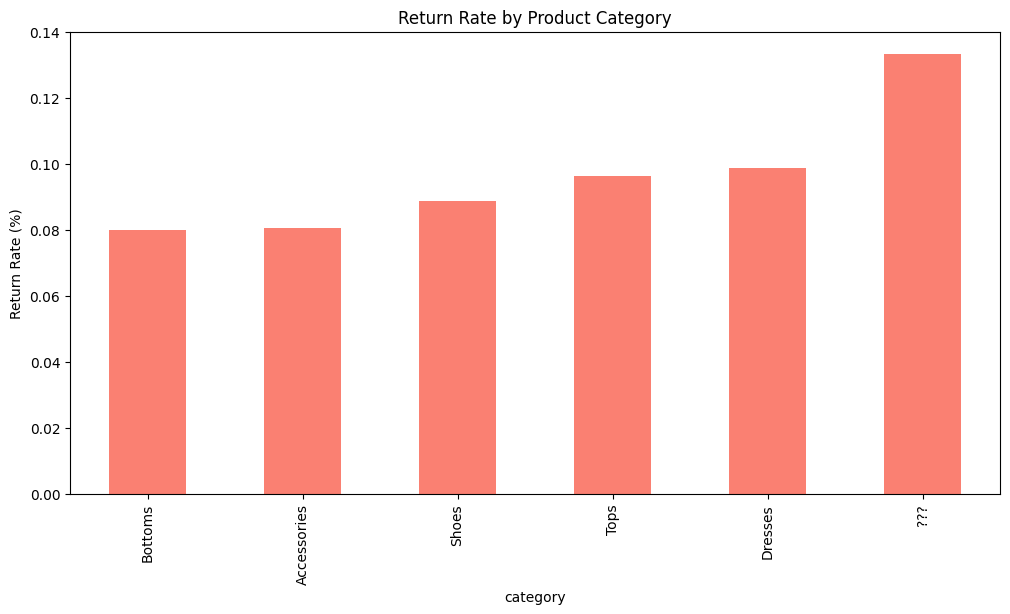

In [14]:
# Return rate by category
returns = df_clean.groupby('category')['returned'].mean().sort_values(ascending=True)
returns.plot(kind='bar', figsize=(12,6), color='salmon')
plt.title("Return Rate by Product Category")
plt.ylabel("Return Rate (%)")
plt.show()

store_size_cat
Medium    3003
Small      780
NaN         16
Large        0
Name: count, dtype: int64


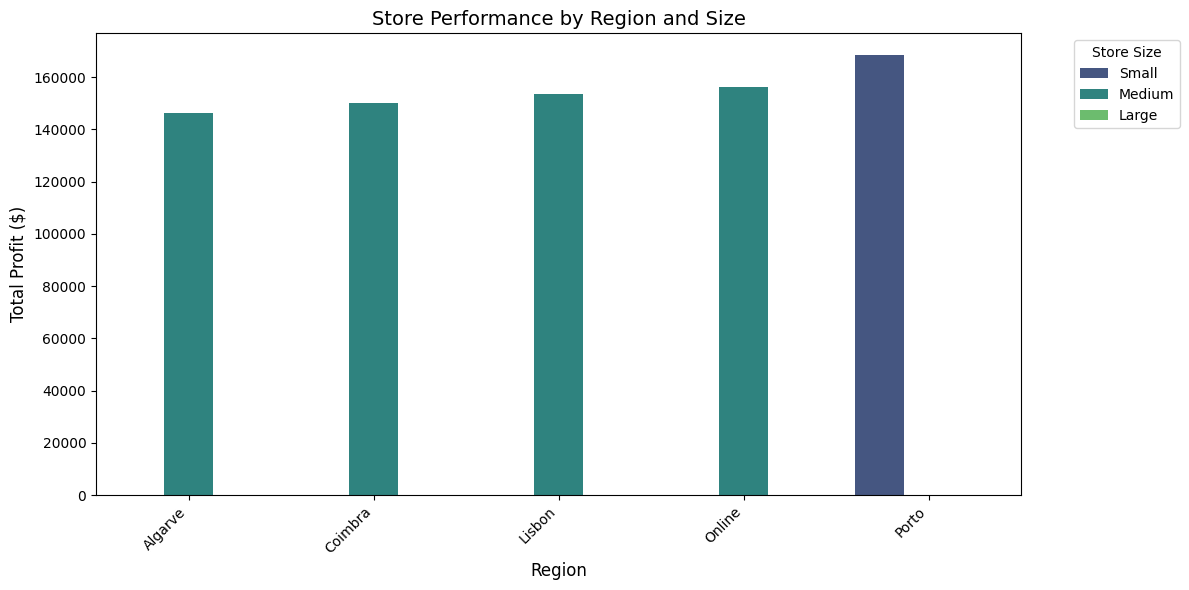

In [15]:
# Bin store sizes into categories
bins = [0, 500, 1000, float('inf')]
labels = ['Small', 'Medium', 'Large']
df_clean['store_size_cat'] = pd.cut(
    df_clean['store_size_m2'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Confirm bins worked
print(df_clean['store_size_cat'].value_counts(dropna=False))

# Aggregate and plot
performance_data = df_clean.groupby(['region', 'store_size_cat'], observed=True)['profit'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='profit', hue='store_size_cat', data=performance_data, palette='viridis')

plt.title('Store Performance by Region and Size', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Store Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


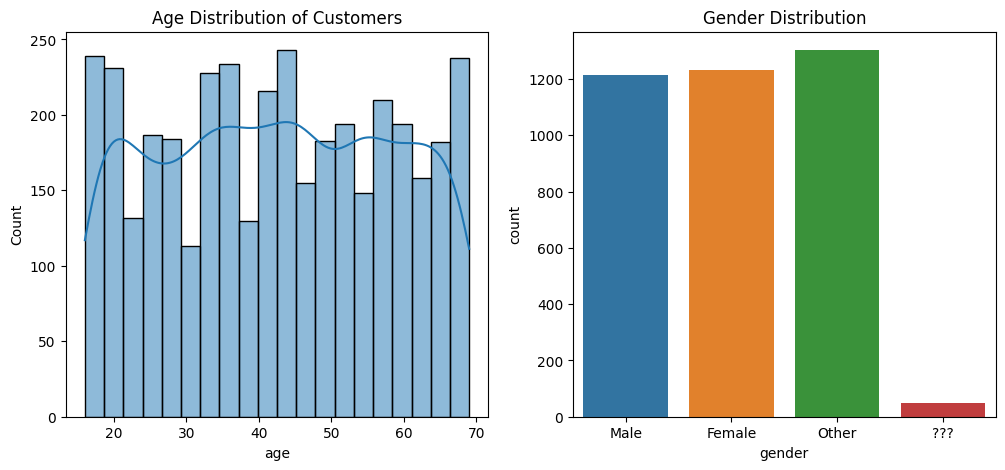

In [16]:
# Customer Demographics
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_clean['age'], bins=20, kde=True, ax=ax[0])
sns.countplot(data=df_clean, x='gender', ax=ax[1])
ax[0].set_title("Age Distribution of Customers")
ax[1].set_title("Gender Distribution")
plt.show()

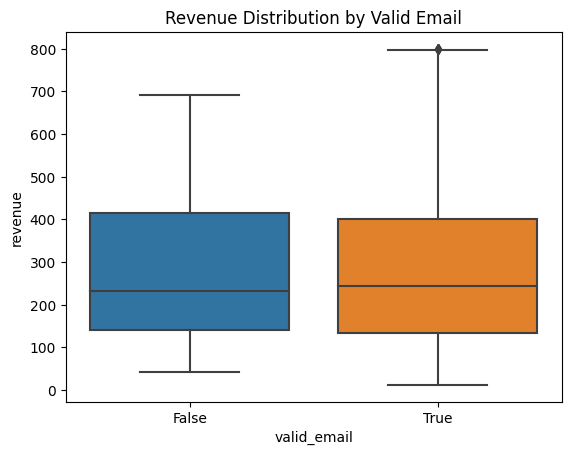

In [17]:
# Email validity vs Revemue
sns.boxplot(data=df_clean, x='valid_email', y='revenue')
plt.title("Revenue Distribution by Valid Email")
plt.show()

# Imputation section

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Separate rows with known and unknown categories
known_data = df_clean[df_clean['category'] != '???']
unknown_data = df_clean[df_clean['category'] == '???']

# Prepare features (price) and target (category)
X_train = known_data[['list_price']]  # Feature: price for training
y_train = known_data['category']  # Target: known categories
X_test = unknown_data[['list_price']]  # Feature: price for rows with '???'

# Scale the price feature (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)  # Adjust n_neighbors as needed
knn.fit(X_train_scaled, y_train)

# Predict missing categories
predicted_categories = knn.predict(X_test_scaled)

# Replace '???' with predicted categories
df_clean.loc[df_clean['category'] == '???', 'category'] = predicted_categories

# Verify the result
print("\nCategory distribution after imputation:")
print(df_clean['category'].value_counts())


Category distribution after imputation:
category
Accessories    796
Dresses        783
Tops           778
Bottoms        738
Shoes          704
Name: count, dtype: int64


In [19]:

class ImputationPipeline:
    """
    Handles missing value imputations for retail transaction data,
    and includes post-imputation visualization diagnostics.
    """

    def __init__(self, visualize: bool = True):
        """
        Parameters
        ----------
        visualize : bool, optional
            Whether to generate diagnostic plots after imputation.
        """
        self.visualize = visualize

    # ====== IMPUTATION METHODS ======
    def _fill_discount(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'discount' in df.columns:
            df['discount'] = df['discount'].fillna(0.0)
        return df

    def _fill_gender(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'gender' in df.columns:
            df['gender'] = df['gender'].replace('???', 'Unknown').fillna('Unknown')
        return df

    def _fill_age(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'age' in df.columns:
            median_age = df['age'].median()
            df['age'] = df['age'].fillna(median_age)
        return df

    def _fill_identifiers(self, df: pd.DataFrame) -> pd.DataFrame:
        for col in ['customer_id', 'email']:
            if col in df.columns:
                df[col] = df[col].fillna('Unknown')
        return df

    def _fill_store_size(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'store_size_m2' in df.columns:
            if 'region' in df.columns:
                df['store_size_m2'] = df.groupby('region')['store_size_m2'].transform(
                    lambda x: x.fillna(x.median())
                )

            overall_median = df['store_size_m2'].median()
            df['store_size_m2'] = df['store_size_m2'].fillna(overall_median)
        return df

    # ====== VISUALIZATION METHODS ======
    def _visualize_imputations(self, df: pd.DataFrame):
        """
        Generate diagnostic plots after imputations to verify distributions.
        """
        num_cols = ['age', 'discount', 'store_size_m2']

        for col in num_cols:
            if col in df.columns:
                plt.figure(figsize=(6, 4))
                sns.histplot(df[col], bins=20, kde=True, color='steelblue', alpha=0.7)
                plt.title(f"Distribution of '{col}' After Imputation")
                plt.xlabel(col)
                plt.ylabel("Frequency")
                plt.tight_layout()
                plt.show()

        # Gender and region counts
        cat_cols = ['gender', 'region']
        for col in cat_cols:
            if col in df.columns:
                plt.figure(figsize=(6, 4))
                df[col].value_counts(dropna=False).plot(kind='bar', color='teal', alpha=0.8)
                plt.title(f"Counts of '{col}' After Imputation")
                plt.xlabel(col)
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()

    # ====== PIPELINE METHODS ======
    def fit(self, df: pd.DataFrame):
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = self._fill_discount(df)
        df = self._fill_gender(df)
        df = self._fill_age(df)
        df = self._fill_identifiers(df)
        df = self._fill_store_size(df)

        if self.visualize:
            self._visualize_imputations(df)

        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)


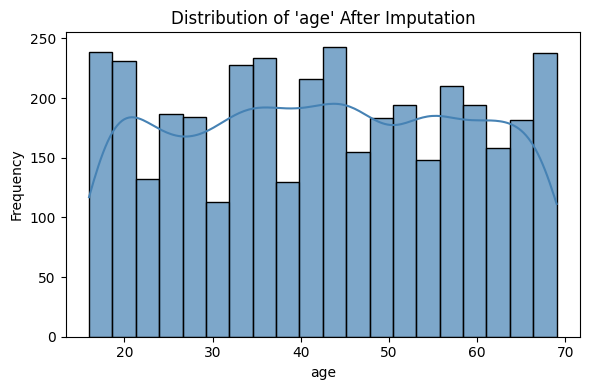

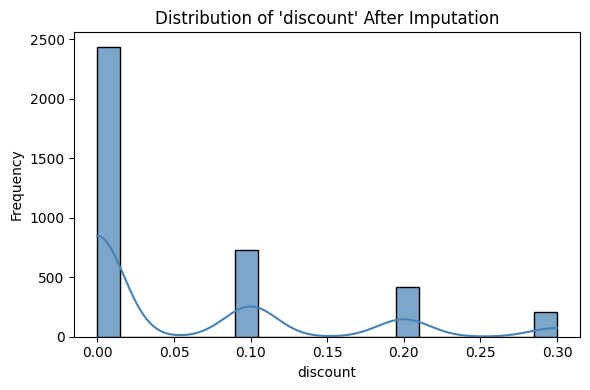

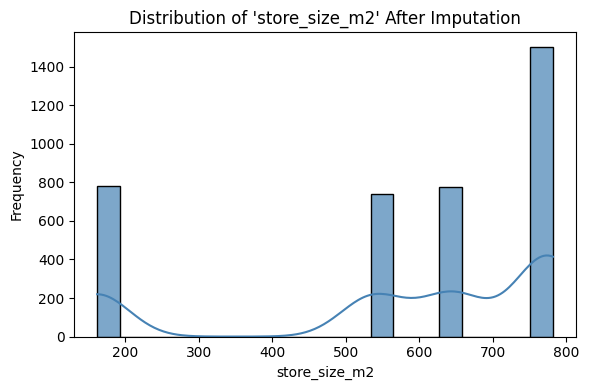

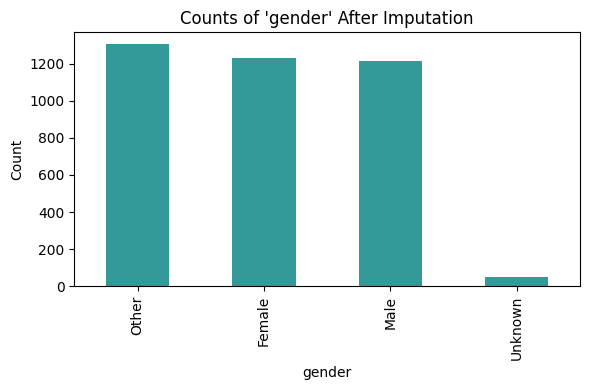

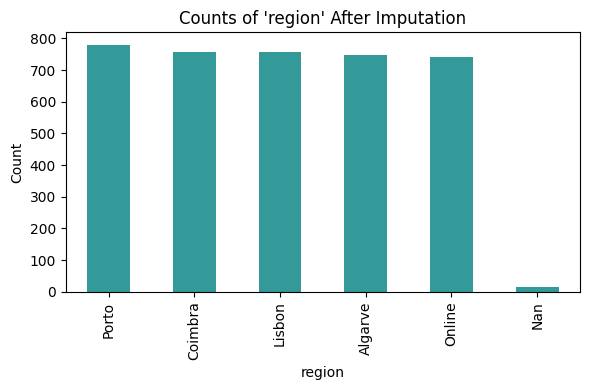

In [20]:
# Initialize and impute
imputer = ImputationPipeline(visualize=True)
df_final = imputer.fit_transform(df_clean)